# DICOM-CT-PD (3rd Generation CT)

In [1]:
from __future__ import annotations
import torch
from torch.nn.functional import pad
from pytomography.metadata import ObjectMeta
from pytomography.algorithms import SART
from pytomography.io.CT import dicom_ct_pd
from pytomography.projectors.CT import CTGen3SystemMatrix
import matplotlib.pyplot as plt
import os


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_cuda.so.1.8.0
    


First, lets specify the paths of all the projection data:

In [2]:
save_path = '/disk1/ct_proj/DICOM-CT-PD_FD' # Path where you downloaded the CT-PD data
paths = [os.path.join(save_path, file) for file in os.listdir(save_path) if '.dcm' in file]

We can load the projections and corresponding metadata as follows
* This may take a couple minutes as the dataset is huge

In [3]:
proj, proj_meta = dicom_ct_pd.get_projections_and_metadata_gen3(paths)

We can view some of the projections:

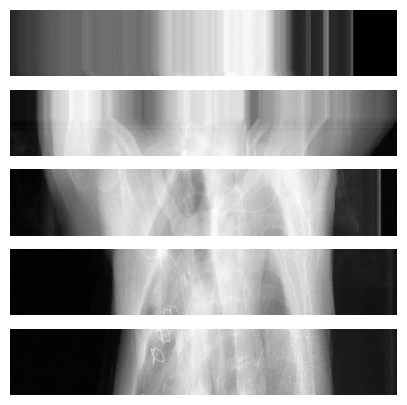

In [4]:
plt.subplots(5,1,figsize=(5,5))
plt.subplot(511)
plt.pcolormesh(proj[0].cpu().T, cmap='Greys_r')
plt.axis('off')
plt.subplot(512)
plt.pcolormesh(proj[1400].cpu().T, cmap='Greys_r')
plt.axis('off')
plt.subplot(513)
plt.pcolormesh(proj[4800].cpu().T, cmap='Greys_r')
plt.axis('off')
plt.subplot(514)
plt.pcolormesh(proj[6400].cpu().T, cmap='Greys_r')
plt.axis('off')
plt.subplot(515)
plt.pcolormesh(proj[8800].cpu().T, cmap='Greys_r')
plt.axis('off')
plt.show()

Now lets set up our object space metadata

In [5]:
dx = dy = dz =  1.0 # mm
Nx = Ny = Nz = 512
object_meta = ObjectMeta(dr=(dx,dx,dx), shape=(Nx,Ny,Nz))

We can create the system matrix as follows. The `N_splits` argument can save on memory if you are using a small number of subsets or have little GPU RAM. The `device='cpu'` means that the projections are expected on CPU (the internal projector code will still use `pytomography.device` and transfer the projections to GPU if needed)

In [6]:
system_matrix = CTGen3SystemMatrix(object_meta, proj_meta, N_splits=1, device='cpu')

Here we reconstruct using SART with 3 iterations and 40 subsets (this takes around 10 mins)

In [7]:
recon_algorithm = SART(system_matrix, proj)
recon = recon_algorithm(n_iters=3, n_subsets=40)

Now we can look at an axial slice:

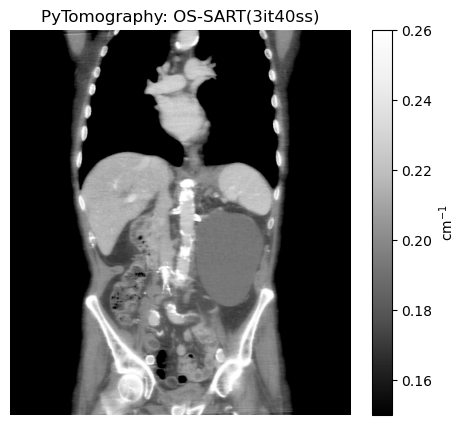

In [8]:
plt.figure(figsize=(5.5,5))
plt.pcolormesh(recon[:,255].cpu().numpy().T * 10, cmap='Greys_r', vmin=0.15, vmax=0.26, shading='gouraud')
plt.ylim(10,500)
plt.axis('off')
plt.colorbar(label='cm$^{-1}$')
plt.title('PyTomography: OS-SART(3it40ss)')
plt.savefig('CT_slice.png', dpi=500, bbox_inches='tight')

* If anyone wants to implement FBP for the geometry of this scanner, please do and submit a pull request! (see the `CTConeBeamFlatPanelSystemMatrix` backward method for how filtered back projection should be implemented)

* If anyone wants to write a DICOM exporter for these CT images, please do, and submit a pull request!